<a href="https://colab.research.google.com/github/zhukeke0107/ComputerVision_Classification/blob/main/01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I'd like to start with easy and simple model and trained in pytorch. 

The website is used as a reference:
https://github.com/bentrevett/pytorch-image-classification

### Reference book: 

- Dive into deep learning
- Deep learning in Pytorch
- Deep Learning


### Medium Blog:



In [1]:
!pip install torchvision

In [2]:
# mnist data will be applied
import torch
from torch import nn, optim
import torch.nn.functional as F

import torch.utils.data as data

# import torchvision.transforms as transforms
from torchvision import datasets, transforms

from sklearn import metrics, decomposition, manifold
import matplotlib.pyplot as plt
import numpy as np
import copy, random, time

In [3]:
# ensure we could reproducible results and set the seed
SEED = 2022
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# connect to colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import os
dir_path = '/content/drive/MyDrive/github/CV/ImageClassification'
os.chdir(dir_path)

In [6]:
!pwd

/content/drive/MyDrive/github/CV/ImageClassification


In [7]:
ROOT = 'data'
train_data = datasets.MNIST(root=ROOT, 
                            train=True, 
                            download=False)

In [8]:
mean = train_data.data.float().mean()/255.0
std = train_data.data.float().std()/255
mean, std

(tensor(0.1307), tensor(0.3081))

In [9]:
 # transform used for data augmented and preprocess
 train_transforms = transforms.Compose([
                              transforms.RandomRotation(5, fill=(0,)),
                              transforms.RandomCrop(28, padding=2),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[mean], std=[std])])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[mean], std=[std])
])
 train_data = datasets.MNIST(root=ROOT, 
                             train=True,
                             download=False,
                             transform=train_transforms)
 
 test_data = datasets.MNIST(root=ROOT,
                            train=False, 
                            download=False, 
                            transform=test_transforms)
 
 len(train_data)
 len(test_data)

10000

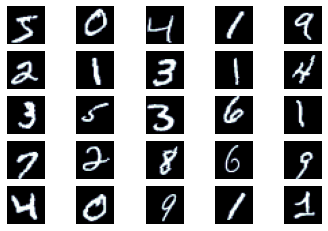

In [10]:
def plot_image(images):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure()
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
    ax.axis('off')

N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_image(images)

In [11]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data)*VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data.dataset.transform = test_transforms

In [12]:
# define dataloader
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [13]:
#define the model
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.input_fc = nn.Linear(input_dim, 250)
    self.hidden_fc = nn.Linear(250, 100)
    self.output_fc = nn.Linear(100, output_dim)

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    h_1 = F.relu(self.input_fc(x))
    h_2 = F.relu(self.hidden_fc(h_1))
    y_pred = self.output_fc(h_2)
    return y_pred, h_2

INPUT_DIM = 28*28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [14]:
# count parameters
def count_parameters(model):
  return np.sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
!pip3 install tqdm

In [17]:
#train the model
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train on gpu
model = model.to(device)
criterion = criterion.to(device)

# calc accuracy
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = torch.sum(top_pred == y.view_as(top_pred))
  acc = correct.float()/y.shape[0]
  return acc

# from tqdm.notenook import tqdm, trange
from tqdm import tqdm_notebook

# epoch
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0.0
  epoch_acc = 0

  model.train()

  for (x, y) in tqdm_notebook(iterator, desc='Training', leave=False):
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    y_pred, _ = model(x)

    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0.0
  epoch_acc = 0

  model.eval()
  with torch.no_grad():
    for (x, y) in tqdm_notebook(iterator, desc='Evaluation', leave=False):
      x = x.to(device)
      y = y.to(device)

      y_pred, _8 = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)


# time calculation
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time - elapsed_mins*60)
  return elapsed_mins, elapsed_secs


import time

EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
  start_time = time.monotonic()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut1-model.pt')
  
  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
  print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
  print(f"\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training:   0%|          | 0/844 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.248 | Train Acc: 92.56%
	Valid Loss: 0.123 | Valid Acc: 96.42%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 0.101 | Train Acc: 96.91%
	Valid Loss: 0.092 | Valid Acc: 97.09%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.070 | Train Acc: 97.82%
	Valid Loss: 0.085 | Valid Acc: 97.40%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.053 | Train Acc: 98.35%
	Valid Loss: 0.072 | Valid Acc: 97.72%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.041 | Train Acc: 98.62%
	Valid Loss: 0.072 | Valid Acc: 97.74%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.034 | Train Acc: 98.88%
	Valid Loss: 0.074 | Valid Acc: 97.69%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.029 | Train Acc: 99.05%
	Valid Loss: 0.064 | Valid Acc: 98.05%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 0.024 | Train Acc: 99.23%
	Valid Loss: 0.095 | Valid Acc: 97.59%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.025 | Train Acc: 99.20%
	Valid Loss: 0.073 | Valid Acc: 97.99%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 13s
	Train Loss: 0.018 | Train Acc: 99.43%
	Valid Loss: 0.067 | Valid Acc: 98.15%


In [21]:
# examine the model
def get_predictions(model, iterator, device):
  model.eval()

  images = []
  labels = []
  probs = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)

      y_pred, _ = model(x)

      y_prob = F.softmax(y_pred)

      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim=0)
  labels = torch.cat(labels, dim=0)
  probs = torch.cat(probs, dim=0)

  return images, labels, probs

In [22]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [27]:
def plot_confusion_matrix(labels, pred_labels):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  cm = metrics.confusion_matrix(labels, pred_labels)
  cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
  cm.plot(values_format='d', cmap='Reds', ax=ax)

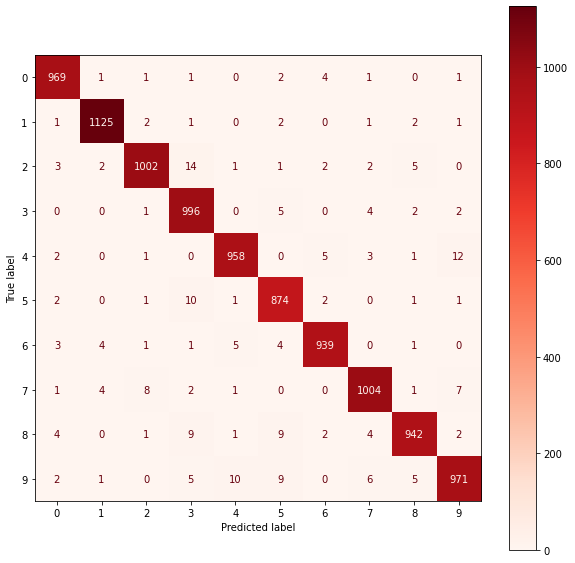

In [28]:
plot_confusion_matrix(labels, pred_labels)

In [34]:
corrects = torch.eq(labels, pred_labels)

In [35]:
torch.sum(corrects).float()/len(labels)

tensor(0.9780)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if not correct:
    incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: )